In [4]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Ordinal Regression/Output')
cur_date = "062024"

library(readxl)
library(openxlsx)
library(tidyverse)
library(gtsummary)
library(ordinalNet)
library(reshape2)
library(rstatix)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpubr)
library(multcomp)
library(rlang)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_061424.xlsx"))


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:rstatix’:

    select


The following object is masked from ‘package:gtsummary’:

    select


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser



Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, flatten, flatten_chr, flatte

In [5]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score
,<chr>,<chr>,<dbl>
1,Cortisol,CS_M_18_B_1,0.4683470
2,Cortisol,CS_F_20_W_2,0.8342112
3,Cortisol,CS_F_20_W_3,0.1603803
4,Cortisol,CS_F_21_W_4,0.4583014
5,Cortisol,CS_M_21_W_5,0.3867217
6,Cortisol,CS_F_22_W_6,0.1712352


Calculating allostatic load (AL) scores for each subject, which serves as a measure for stress.

1. **Acute Stress**

    In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 3 acute stress biomarkers (Noradrenaline, epinephrine, and cortisol).
    

3. **Chronic (secondary/tertiary) Stress**
   
    No deriving of ordinal weights in this analysis, since we don't have an outcome that we measured associated with chronic stress. We'll include 4 chronic stress biomarkers (CRP, Hba1c, Fibrnogen, and HDL). 
    

5. **Overall AL**
   
    Summing the acute and chronic AL scores.

# Acute Sress
Starting by combining the dataframes.

In [6]:
# creating a vector for variables that increase acute stress
acute_biomarkers = c('Cortisol','Noradrenaline','Epinephrine')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining acute biomarkers only
        filter(Variable %in% acute_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:10,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(mediator_scores_df)

head(reg_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.3867217,0.9216080,0.02133767,N
CS_M_24_W_8,0.4378417,0.5058597,0.02155180,N
CS_M_25_W_10,0.2932014,0.8479016,0.18657420,E
CS_M_28_W_16,0.2416750,0.5058597,0.48633181,N
CS_M_29_W_17,0.5472276,0.3352036,0.35658497,N
CS_F_31_B_21,0.3620846,0.2770528,0.16448963,N


## Assessing Distributions

Looking at the distributions of blood pressure classifications and the mediator scores for each variable.

In [7]:
table(reg_df$BP_Classification)


 1  2  E  N 
 6  1  9 18 

The stage 1 and stage 2 classes are on the smaller side with 6 and 1 subject, respectively. There weren't enough observation of the stage 2 class to perform SMOTE; therefore, the blood pressure classes will be condensed in two different ways:

+ **3 classes**: Normal subjects, at risk (elevated) subjects, and hypertensive subjects (formerly stage 1 and stage 2 subjects)
+ **2 classes**: Normal subjects and hypertensive subjects (formerly elevated, stage 1, and stage 2 subjects)

In [8]:
three_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2"), "H", BP_Classification))

two_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2", "E"), "H", BP_Classification))

# turning BP into a factor
three_reg_df$BP_Classification = factor(three_reg_df$BP_Classification, levels = c("N", "E", "H"))
two_reg_df$BP_Classification = factor(two_reg_df$BP_Classification, levels = c("N", "H"))

In [9]:
table(two_reg_df$BP_Classification)
table(three_reg_df$BP_Classification)


 N  H 
18 16 


 N  E  H 
18  9  7 

Now assessing normality of the biomarkers using a shapiro wilk test.

In [10]:
# using a shapiro wilk test to assess normality
do.call(rbind.data.frame, apply(reg_df[,2:4], 2, shapiro.test))[,1:3] %>%
    # adding a column that clarifies whether or not a variable is normally distributed or not
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.7429965,2.411103e-06,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9351777,4.436357e-02,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9389878,5.752138e-02,Shapiro-Wilk normality test,Normal


Only 1 variable was normally distributed; therefore, we'll perform a data transformation (pseudo log 2) to see if that helps.

In [11]:
pslog2_df = reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(pslog2_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,E
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,N
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


In [12]:
do.call(rbind.data.frame, apply(pslog2_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.8080826,3.687146e-05,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9528941,1.498883e-01,Shapiro-Wilk normality test,Normal
Epinephrine,0.9413655,6.770597e-02,Shapiro-Wilk normality test,Normal


Now we have 2 out of 3 variables that are normally distributed.

In [13]:
# need to use the pslog2 data
three_reg_df = three_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

two_reg_df = two_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(three_reg_df)

Subject_ID,Cortisol,Noradrenaline,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<fct>
CS_M_21_W_5,0.4716783,0.9423141,0.03045993,N
CS_M_24_W_8,0.5239048,0.5905873,0.03076236,N
CS_M_25_W_10,0.3709470,0.8858879,0.24680232,E
CS_M_28_W_16,0.3122876,0.5905873,0.57175622,N
CS_M_29_W_17,0.6296855,0.4170597,0.43997942,N
CS_F_31_B_21,0.4458163,0.3528182,0.21969779,N


## Summary Statistics

Determining if there are any significant differences between the features for each outcome class.

In [14]:
# 3 class outcome
inner_join(three_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:5]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "aov",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`
Warning for variable 'Smoking_Status':
simpleWarning in stats::chisq.test(x = c("CS", "CS", "CS", "CS", "CS", "CS", "CS", : Chi-squared approximation may be incorrect

Warning for variable 'Sex':
simpleWarning in stats::chisq.test(x = c("M", "M", "M", "M", "M", "F", "M", "M", : Chi-squared approximation may be incorrect

Warning for variable 'Race':
simpleWarning in stats::chisq.test(x = c("W", "W", "W", "W", "W", "B", "W", "B", : Chi-squared approximation may be incorrect



**Characteristic**,**N**,"**N**, N = 18","**E**, N = 9","**H**, N = 7",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.17),0.36 (0.07),0.44 (0.20),0.4
Noradrenaline,34,0.50 (0.31),0.47 (0.23),0.40 (0.34),0.8
Epinephrine,34,0.26 (0.17),0.22 (0.12),0.16 (0.15),0.3
Smoking_Status,34,NA,NA,NA,0.9
CS,NA,9 (50%),5 (56%),3 (43%),NA
NS,NA,9 (50%),4 (44%),4 (57%),NA
Sex,34,NA,NA,NA,0.2
F,NA,12 (67%),4 (44%),6 (86%),NA
M,NA,6 (33%),5 (56%),1 (14%),NA


In [15]:
# two class outcome
inner_join(two_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:5]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "t.test",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`


**Characteristic**,**N**,"**N**, N = 18","**H**, N = 16",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.46 (0.17),0.40 (0.14),0.3
Noradrenaline,34,0.50 (0.31),0.44 (0.27),0.6
Epinephrine,34,0.26 (0.17),0.19 (0.13),0.2
Smoking_Status,34,NA,NA,>0.9
CS,NA,9 (50%),8 (50%),NA
NS,NA,9 (50%),8 (50%),NA
Sex,34,NA,NA,>0.9
F,NA,12 (67%),10 (62%),NA
M,NA,6 (33%),6 (38%),NA


## Ordinal Regression

Using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 3 biomarkers. Just doing this to get weights of these variables.

In [16]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) 
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
three_weights_df = estimateOrdWeights(three_reg_df, 'BP_Classification', biomarker_coefficients)
two_weights_df = estimateOrdWeights(two_reg_df, 'BP_Classification', biomarker_coefficients)

three_weights_df
two_weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.7097551
Noradrenaline,0.1568101
Cortisol,0.1334348


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.58343639
Cortisol,0.34828091
Noradrenaline,0.06828269


## Ordinal Weights Visualization

In [17]:
# creating 1 df
weights_df = cbind(rbind(three_weights_df, two_weights_df), 
                   # adding a col that specificies the number of classes of blood pressure
                   Blood_Pressure_Class_No = c(rep(3, length(three_weights_df$Variable)), 
                                               rep(2, length(three_weights_df$Variable)))) %>% 
    # getting the circle positions for the text labels
    group_by(Blood_Pressure_Class_No) %>%
    mutate(csum = rev(cumsum(rev(Coefficient))), 
         pos = Coefficient/2 + lead(csum, 1),
         pos = if_else(is.na(pos), Coefficient/2, pos))

head(weights_df)

Variable,Coefficient,Blood_Pressure_Class_No,csum,pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Epinephrine,0.70975508,3,1.00000000,0.64512246
Noradrenaline,0.15681012,3,0.29024492,0.21183986
Cortisol,0.13343480,3,0.13343480,0.06671740
Epinephrine,0.58343639,2,1.00000000,0.70828180
Cortisol,0.34828091,2,0.41656361,0.24242315
Noradrenaline,0.06828269,2,0.06828269,0.03414135


In [18]:
options(repr.plot.width=10, repr.plot.height=10) #changing size

piechart3 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 3), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 3), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 3 Blood Pressure Classes") + 
  scale_fill_npg()

col_palette = pal_npg()(7)

piechart2 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 2), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 2), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 2 Blood Pressure Classes") + 
  scale_fill_manual(values = col_palette[c(1,3,2)])

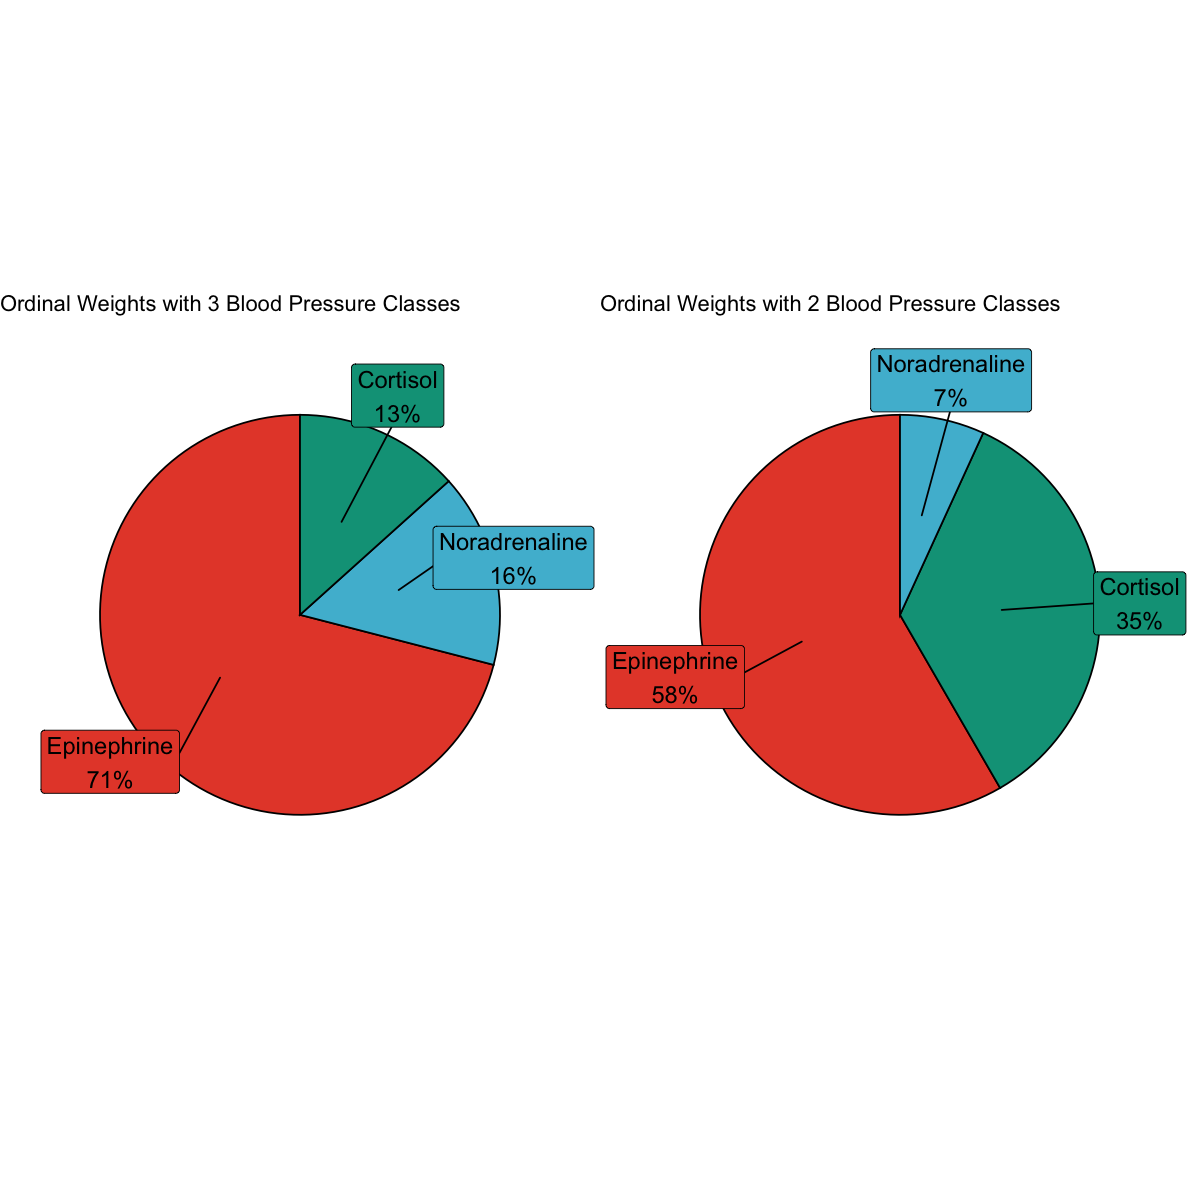

In [19]:
plot_grid(piechart3, piechart2)

Based on these results, epinephrine had the largest contribution to blood pressure classification in both cases. 

## Acute Stress Summation

Now that we have these weights from the ordinal regression, we'll calculate stress scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 4 acute biomarkers (cortisol, noradrenaline, epinephrine, fibrinogen). AL scores will be calculated for all 63 subjects not just the 34 with BP data. The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + Epinephrine ordinal weight * Epinephrine score...

In [20]:
acute_stress = function(weights_df){
    # add words!!
    
    # combining the mediator scores for all 63 subjects with the ordinal weights into one dataframe
    wider_weights_df = mediator_scores_df %>%
        filter(Variable %in% acute_biomarkers) %>%
        mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
        dcast(Variable ~ Subject_ID, value.var = "Mediator_Score") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        dplyr::select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Acute_Stress = apply(multiplication_df, 2, sum)) %>%
        arrange(-Acute_Stress) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
three_acute_stress_df = acute_stress(three_weights_df)
two_acute_stress_df = acute_stress(two_weights_df)

head(three_acute_stress_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Subject_ID,Acute_Stress
,<chr>,<dbl>
1,NS_M_28_W_51,0.8069382
2,NS_F_23_W_41,0.5635610
3,CS_M_28_W_16,0.5400870
4,NS_F_21_W_38,0.5112396
5,CS_M_29_W_17,0.4616988
6,NS_F_38_B_61,0.4394047


# Chronic Stress Summation

This involves normalizing their mediator scores, multiplying HDL by -1 since it's considered protective against atherosclerotic risk, and summing them to get the chronic stress score.

These biomarkers are essentially weighted with 1 or -1.

In [21]:
chronic_biomarkers = c('Hba1c','CRP', 'HDL','Fibrinogen')

chronic_stress_df = mediator_scores_df %>%
    # filtering for chronic biomarkers
    filter(Variable %in% chronic_biomarkers) %>%
    # normalizing
    mutate(Mediator_Score = log2(Mediator_Score + 1)) %>%
    # making HDL negative
    mutate(Mediator_Score = ifelse(Variable == "HDL", Mediator_Score * -1, Mediator_Score)) %>%
    # summing for each subject
    group_by(Subject_ID) %>%
    summarize(Summed_Score = sum(Mediator_Score)) %>%
    # rescaling so that these numbers fall between 0 and 1
    mutate(Chronic_Stress = (Summed_Score  - min(Summed_Score))/ (max(Summed_Score) - min(Summed_Score))) %>%
    dplyr::select(-Summed_Score) %>%
    arrange(-Chronic_Stress)

head(chronic_stress_df)

Subject_ID,Chronic_Stress
<chr>,<dbl>
NS_F_42_B_62,1.0000000
CS_F_39_W_32,0.8849612
NS_F_28_B_53,0.8810224
NS_F_35_B_59,0.8382134
NS_F_27_B_50,0.8268365
NS_F_23_W_41,0.7215899


# Overall AL

Summing the acute and chronic stress scores. These scores range from 0-2.

In [22]:
allostatic_three_df = inner_join(three_acute_stress_df, chronic_stress_df) %>%
    mutate(Allostatic_Load = Acute_Stress + Chronic_Stress)

allostatic_two_df = inner_join(two_acute_stress_df, chronic_stress_df) %>%
    mutate(Allostatic_Load = Acute_Stress + Chronic_Stress)

head(allostatic_three_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load
,<chr>,<dbl>,<dbl>,<dbl>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227


Before testing for statistical differences, let's check out the distributions for each stress variable.

In [23]:
# seeing if this data is normal
do.call(rbind.data.frame, apply(allostatic_three_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

do.call(rbind.data.frame, apply(allostatic_two_df[,2:4], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Acute_Stress,0.9145401,0.0003314206,Shapiro-Wilk normality test,Non-normal
Chronic_Stress,0.9517668,0.0150754390,Shapiro-Wilk normality test,Non-normal
Allostatic_Load,0.9521905,0.0158159192,Shapiro-Wilk normality test,Non-normal


,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Acute_Stress,0.9295009,0.00140166,Shapiro-Wilk normality test,Non-normal
Chronic_Stress,0.9517668,0.01507544,Shapiro-Wilk normality test,Non-normal
Allostatic_Load,0.9556824,0.02356695,Shapiro-Wilk normality test,Non-normal


In [24]:
# # it's not so normalizing
# norm_allostatic_three_df = allostatic_three_df %>%
#     mutate(across(Acute_Stress:Allostatic_Load, ~ log2(.x + 1)))

# norm_allostatic_two_df = allostatic_two_df %>%
#     mutate(across(Acute_Stress:Allostatic_Load, ~ log2(.x + 1)))

# head(norm_allostatic_three_df)

In [25]:
# # seeing if this data is normal
# do.call(rbind.data.frame, apply(norm_allostatic_three_df[,2:4], 2, shapiro.test))[,1:3] %>%
#     mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

# do.call(rbind.data.frame, apply(norm_allostatic_two_df[,2:4], 2, shapiro.test))[,1:3] %>%
#     mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


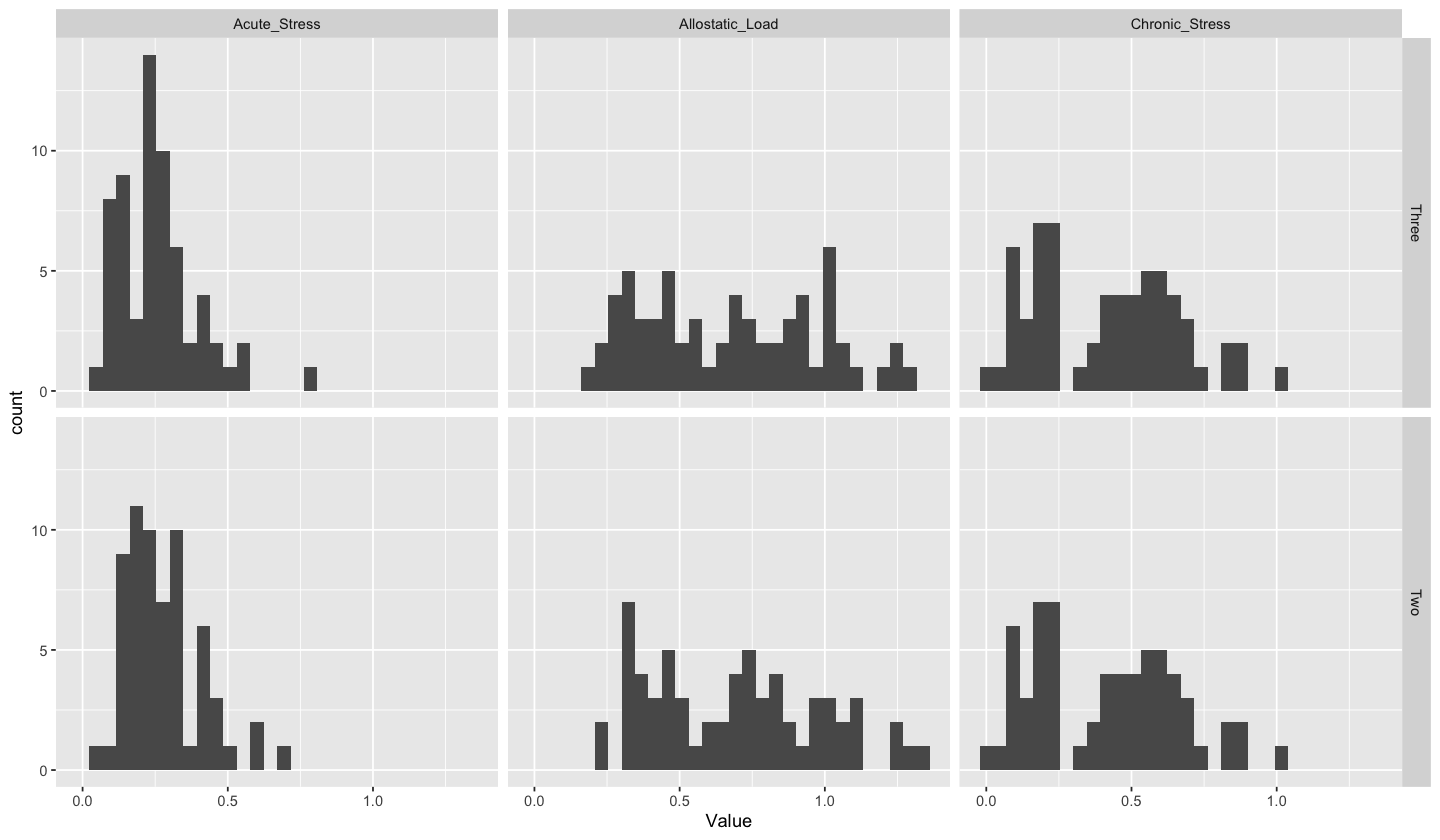

In [26]:
# creating histograms to visualize distribution of acute, chronic, and overall scores
# creating a longer df for plotting
longer_allostatic_three_df = pivot_longer(allostatic_three_df, cols = 2:4, 
                                          names_to = "Variable", values_to = "Value") %>%
                                    mutate(No_Weighted_Class = "Three")
longer_allostatic_two_df = pivot_longer(allostatic_two_df, cols = 2:4, 
                                          names_to = "Variable", values_to = "Value") %>%
                                    mutate(No_Weighted_Class = "Two")

longer_allostatic_df = rbind(longer_allostatic_three_df, longer_allostatic_two_df)

options(repr.plot.width=12, repr.plot.height=7) #changing size
ggplot(longer_allostatic_df) + 
  geom_histogram(aes(x = Value)) + 

  facet_grid(No_Weighted_Class~Variable)

These data aren't normally distributed. However, I'm moving forward and creating the dataframe necessary to run the anova tests.

In [27]:
# adding in demographic info for each subject
three_anova_df = inner_join(allostatic_three_df, subject_info_df[,c(3,5,6,8)])
two_anova_df = inner_join(allostatic_two_df, subject_info_df[,c(3,5,6,8)])


# converting into factors
three_anova_df$Smoking_Status = factor(three_anova_df$Smoking_Status, levels = c("NS", "CS"))
three_anova_df$Sex = factor(three_anova_df$Sex, levels = c("M", "F"))
three_anova_df$Race = factor(three_anova_df$Race, levels = c("W", "B"))
two_anova_df$Smoking_Status = factor(two_anova_df$Smoking_Status, levels = c("NS", "CS"))
two_anova_df$Sex = factor(two_anova_df$Sex, levels = c("M", "F"))
two_anova_df$Race = factor(two_anova_df$Race, levels = c("W", "B"))

head(three_anova_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Acute_Stress,Chronic_Stress,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,NS_M_28_W_51,0.8069382,0.09677053,0.9037087,NS,M,W
2,NS_F_23_W_41,0.5635610,0.72158988,1.2851509,NS,F,W
3,CS_M_28_W_16,0.5400870,0.32974467,0.8698317,CS,M,W
4,NS_F_21_W_38,0.5112396,0.51026534,1.0215049,NS,F,W
5,CS_M_29_W_17,0.4616988,0.38316708,0.8448658,CS,M,W
6,NS_F_38_B_61,0.4394047,0.64381800,1.0832227,NS,F,B


In [28]:
# looking at counts for each variable
# smoking status and sex
table(three_anova_df[,c(5:6)])
chisq.test(table(three_anova_df[,c(5:6)]))
# smoking status and race
table(three_anova_df[,c(5,7)])
chisq.test(table(three_anova_df[,c(5,7)]))
# race and sex
table(three_anova_df[,c(6:7)])
chisq.test(table(three_anova_df[,c(6:7)]))

              Sex
Smoking_Status  M  F
            NS  7 23
            CS 16 17


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_anova_df[, c(5:6)])
X-squared = 3.2722, df = 1, p-value = 0.07046


              Race
Smoking_Status  W  B
            NS 16 14
            CS 16 17


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_anova_df[, c(5, 7)])
X-squared = 0.017465, df = 1, p-value = 0.8949


   Race
Sex  W  B
  M 12 11
  F 20 20


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(three_anova_df[, c(6:7)])
X-squared = 5.4891e-31, df = 1, p-value = 1


Although there were no significant differences between the demographic variables, it's clear that our dataset underrepresents non-smoking men.

# Statistical Tests of AL and Stress Scores
Now testing for statistical differences based on sex, race, and smoking status using a two way anova and the tukey's post hoc tests. 

## Allostatic Load

In [29]:
get_anova = function(anova_df, variable1, variable2, outcome, bp_class){
    # add words!!
    # creating a function to run an anova

    # runing anova
    anova_results = aov(eval(rlang::parse_expr(outcome)) ~ eval(rlang::parse_expr(variable1)) * eval(rlang::parse_expr(variable2)), 
                        data = anova_df) 
    # type 3 anova
    anova_type3 = Anova(anova_results, type = 'III')

    # extract f and p values
    anova_summary = anova_type3[2:4,3:4]
    colnames(anova_summary) = c("F_Value", "P_Value")

    # creating df to be exported
    anova_values = data.frame(Outcome = outcome, BP_Class = bp_class, 
                              Comparison = c(variable1, variable2, paste(variable1, ":", variable2)), anova_summary)
    # removing row names
    rownames(anova_values) = NULL
                
    return(anova_values)
                
    }

In [34]:
# calling fn
three_anova_smoking_race_AL = get_anova(three_anova_df, 'Smoking_Status', 'Race', 'Allostatic_Load', "Three")
three_anova_smoking_sex_AL = get_anova(three_anova_df, 'Smoking_Status', 'Sex', 'Allostatic_Load', "Three")
three_anova_sex_race_AL = get_anova(three_anova_df, 'Sex', 'Race', 'Allostatic_Load', "Three")
two_anova_smoking_race_AL = get_anova(two_anova_df, 'Smoking_Status', 'Race', 'Allostatic_Load', "Two")
two_anova_smoking_sex_AL = get_anova(two_anova_df, 'Smoking_Status', 'Sex', 'Allostatic_Load', "Two")
two_anova_sex_race_AL = get_anova(two_anova_df, 'Sex', 'Race', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_anova_df = unique(rbind(three_anova_smoking_race_AL, three_anova_smoking_sex_AL,
                            three_anova_sex_race_AL, two_anova_smoking_race_AL, two_anova_smoking_sex_AL,
                            two_anova_smoking_race_AL)) %>%
    # adjusting
    #group_by(BP_Class) %>%
    mutate(P_Adj = p.adjust(as.numeric(as.character(P_Value)), method = "fdr"))

In [35]:
# viewing sig results
allostatic_anova_df %>%
    filter(P_Adj < 0.1)

Outcome,BP_Class,Comparison,F_Value,P_Value,P_Adj
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Allostatic_Load,Three,Race,5.679911,0.020398427,0.07649410
Allostatic_Load,Three,Sex,5.813981,0.019031417,0.07649410
Allostatic_Load,Three,Sex : Race,9.856932,0.002642525,0.03963787
Allostatic_Load,Two,Race,6.613339,0.012661308,0.07649410


There are statistically significant differences in allostatic load based on race, sex, and the interaction between race and sex using ordinal weights from blood pressure classification with three classes.

Only race was significant when using ordinal weights from blood pressure classification with two classes.

In [44]:
get_tukey = function(anova_df, variable1, variable2, outcome, bp_class){
    # add words!!
    # creating a function to run tukeys tests
    
    # tukeys
    tukey_df = anova_df %>%
        tukey_hsd(as.formula(paste0(outcome, "~", variable1, "*", variable2)))
    
    # NEED TO RUN TUKEY'S FROM A TYPE III ANOVA!!

    # creating df to be exported
    tukey_values = data.frame(Outcome = outcome, BP_Class = bp_class, tukey_df[,c(1:3,5,8,9)])
    

    return(tukey_values)
}

# calling fn
three_tukey_smoking_race_AL = get_tukey(three_anova_df, 'Smoking_Status', 'Race', 'Allostatic_Load', "Three")
three_tukey_smoking_sex_AL = get_tukey(three_anova_df, 'Smoking_Status', 'Sex', 'Allostatic_Load', "Three")
three_tukey_sex_race_AL = get_tukey(three_anova_df, 'Sex', 'Race', 'Allostatic_Load', "Three")
two_tukey_smoking_race_AL = get_tukey(two_anova_df, 'Smoking_Status', 'Race', 'Allostatic_Load', "Two")
two_tukey_smoking_sex_AL = get_tukey(two_anova_df, 'Smoking_Status', 'Sex', 'Allostatic_Load', "Two")
two_tukey_sex_race_AL = get_tukey(two_anova_df, 'Sex', 'Race', 'Allostatic_Load', "Two")

# creating 1 df
allostatic_tukey_df = unique(rbind(three_tukey_smoking_race_AL, three_tukey_smoking_sex_AL,
                            three_tukey_sex_race_AL, two_tukey_smoking_race_AL, two_tukey_smoking_sex_AL,
                            two_tukey_smoking_race_AL)) %>%
    # only need results from interactions
    filter(grepl(":", term))

In [45]:
# viewing sig results
allostatic_tukey_df %>%
    filter(p.adj < 0.1)

Outcome,BP_Class,term,group1,group2,estimate,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Allostatic_Load,Three,Smoking_Status:Race,NS:W,NS:B,0.2543682,0.09150,ns
Allostatic_Load,Three,Smoking_Status:Race,CS:W,NS:B,0.2731844,0.06120,ns
Allostatic_Load,Three,Smoking_Status:Race,NS:B,CS:B,-0.2470506,0.09900,ns
Allostatic_Load,Three,Sex:Race,M:W,F:W,-0.2484320,0.08600,ns
Allostatic_Load,Three,Sex:Race,F:W,F:B,0.2979211,0.00776,**
Allostatic_Load,Two,Smoking_Status:Race,NS:W,NS:B,0.2640616,0.05940,ns
Allostatic_Load,Two,Smoking_Status:Race,CS:W,NS:B,0.2777036,0.04310,*
Allostatic_Load,Two,Smoking_Status:Race,NS:B,CS:B,-0.2529730,0.07060,ns


Now visualizing sig comparisons.

## Sex & Race Boxplot

In [117]:
boxplot_df = three_anova_df %>%
    unite(`Sex:Race`, Sex, Race, sep = ":", remove = FALSE)

# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
adjusted_t_test_p_values = compare_means(Allostatic_Load ~ Sex:Race, data = boxplot_df, method = "t.test") %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.2, 1, 1, 1.5, 1, 1))

adjusted_t_test_p_values

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Allostatic_Load,M:W,F:W,0.01283778,0.064,0.0128,.,T-test,1.2
Allostatic_Load,M:W,F:B,0.60244164,0.840,0.6024,ns,T-test,1.0
Allostatic_Load,M:W,M:B,0.10483932,0.310,0.1048,ns,T-test,1.0
Allostatic_Load,F:W,F:B,0.00383513,0.023,0.0038,*,T-test,1.5
Allostatic_Load,F:W,M:B,0.41956423,0.840,0.4196,ns,T-test,1.0
Allostatic_Load,F:B,M:B,0.04244168,0.170,0.0424,ns,T-test,1.0


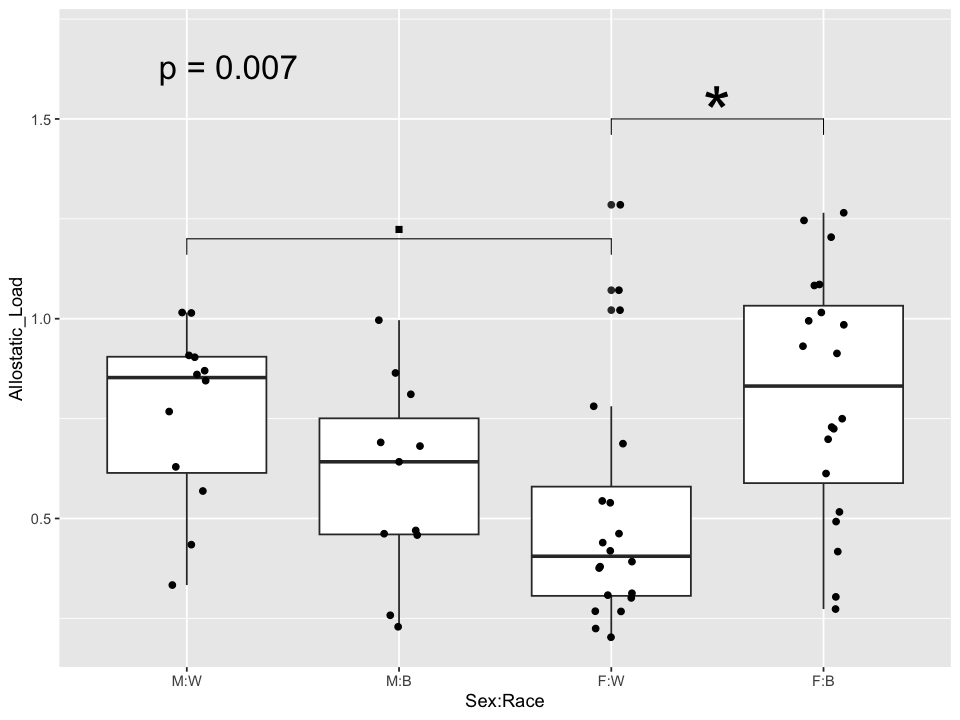

In [73]:
options(repr.plot.width=8, repr.plot.height=6) #changing size

# only adding asterisks for comparisons that are significant
#significant_comparisons <- list(c("M:W", "F:W"), c("F:W", "F:B"))#, c("M:B", "F:B"))

ggplot(data = boxplot_df, aes(x = Sex:Race, y = Allostatic_Load)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1.7) + 

  # overall anova p value
  stat_anova_test(wid = "Sex:Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.6) +
#   # unadjusted p value
#   stat_compare_means(comparisons = significant_comparisons, label = "p.signif", hide.ns = TRUE, size = 10) #+

  # adjusted p value
  stat_pvalue_manual(adjusted_t_test_p_values %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 15)

## Acute Stress

In [83]:
# calling anova fn
three_anova_smoking_race_acute = get_anova(three_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Three")
three_anova_smoking_sex_acute = get_anova(three_anova_df, 'Smoking_Status', 'Sex', 'Acute_Stress', "Three")
three_anova_sex_race_acute = get_anova(three_anova_df, 'Sex', 'Race', 'Acute_Stress', "Three")
two_anova_smoking_race_acute = get_anova(two_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Two")
two_anova_smoking_sex_acute = get_anova(two_anova_df, 'Smoking_Status', 'Sex', 'Acute_Stress', "Two")
two_anova_sex_race_acute = get_anova(two_anova_df, 'Sex', 'Race', 'Acute_Stress', "Two")

In [84]:
# creating 1 df
acute_anova_df = unique(rbind(three_anova_smoking_race_acute, three_anova_smoking_sex_acute,
                            three_anova_sex_race_acute, two_anova_smoking_race_acute, 
                              two_anova_smoking_sex_acute, two_anova_smoking_race_acute)) %>%
    # adjusting
    #group_by(BP_Class) %>%
    mutate(P_Adj = p.adjust(as.numeric(as.character(P_Value)), method = "fdr"))

In [87]:
# viewing sig results
acute_anova_df %>%
    filter(P_Adj < 0.1)

Outcome,BP_Class,Comparison,F_Value,P_Value,P_Adj
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Acute_Stress,Three,Sex,8.157491,0.005912095,0.06512833
Acute_Stress,Three,Race,6.557060,0.013025666,0.06512833
Acute_Stress,Three,Sex : Race,6.574596,0.012910961,0.06512833


There are statistically significant differences in acute stress based on race, sex, and the interaction between race and sex using ordinal weights from blood pressure classification with three classes.

In [92]:
# calling fn
three_tukey_smoking_race_acute = get_tukey(three_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Three")
three_tukey_smoking_sex_acute = get_tukey(three_anova_df, 'Smoking_Status', 'Sex', 'Acute_Stress', "Three")
three_tukey_sex_race_acute = get_tukey(three_anova_df, 'Sex', 'Race', 'Acute_Stress', "Three")
two_tukey_smoking_race_acute = get_tukey(two_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Two")
two_tukey_smoking_sex_acute = get_tukey(two_anova_df, 'Smoking_Status', 'Sex', 'Acute_Stress', "Two")
two_tukey_sex_race_acute = get_tukey(two_anova_df, 'Sex', 'Race', 'Acute_Stress', "Two")

# creating 1 df
acute_tukey_df = unique(rbind(three_tukey_smoking_race_acute, three_tukey_smoking_sex_acute,
                            three_tukey_sex_race_acute, two_tukey_smoking_race_acute, 
                            two_tukey_smoking_sex_acute, two_tukey_smoking_race_acute)) %>%
    # only need results from interactions
    filter(grepl(":", term))

In [93]:
# viewing sig results
acute_tukey_df %>%
    filter(p.adj < 0.1)

Outcome,BP_Class,term,group1,group2,estimate,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Acute_Stress,Three,Smoking_Status:Sex,NS:M,CS:F,-0.15691188,0.0511,ns
Acute_Stress,Three,Sex:Race,M:W,F:W,-0.13763563,0.0294,*
Acute_Stress,Three,Sex:Race,M:W,M:B,-0.14106353,0.0610,ns
Acute_Stress,Two,Smoking_Status:Sex,NS:F,CS:F,-0.09702454,0.0855,ns


There are statistically significant differences in acute stress between non-smokers and cigarette smokers (p value = 0.02). The interaction between sex and race was significant when using the ordinal weights derived from the 3 class BP prediction. Tukey's post hoc tests revealed that white males have a lower acute stress than white females (p adj < 0.05).?????

### Sex & Race Boxplot

In [94]:
# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
adjusted_t_test_p_values = compare_means(Acute_Stress ~ Sex:Race, data = boxplot_df, method = "t.test") %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.2, 1, 1, 1.5, 1, 1))

adjusted_t_test_p_values

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,M:W,F:W,0.03099272,0.15,0.031,ns,T-test,1.2
Acute_Stress,M:W,F:B,0.09862810,0.39,0.099,ns,T-test,1.0
Acute_Stress,M:W,M:B,0.02554288,0.15,0.026,ns,T-test,1.0
Acute_Stress,F:W,F:B,0.37195378,0.91,0.372,ns,T-test,1.5
Acute_Stress,F:W,M:B,0.93021694,0.93,0.930,ns,T-test,1.0
Acute_Stress,F:B,M:B,0.30403489,0.91,0.304,ns,T-test,1.0


### Smoking Status & Sex Boxplot

In [106]:
boxplot_df = three_anova_df %>%
    unite(`Sex:Smoking_Status`, Sex, Smoking_Status, sep = ":", remove = FALSE)

# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
adjusted_t_test_p_values = compare_means(Acute_Stress ~ Sex:Smoking_Status, data = boxplot_df, 
                                         method = "t.test") %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.2, 1, 1, 1.5, 0.7, 1))

adjusted_t_test_p_values

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Acute_Stress,M:NS,F:NS,0.535800092,1.000,0.5358,ns,T-test,1.2
Acute_Stress,M:NS,M:CS,0.467262038,1.000,0.4673,ns,T-test,1.0
Acute_Stress,M:NS,F:CS,0.122467410,0.490,0.1225,ns,T-test,1.0
Acute_Stress,F:NS,M:CS,0.790013727,1.000,0.7900,ns,T-test,1.5
Acute_Stress,F:NS,F:CS,0.008948007,0.054,0.0089,.,T-test,0.7
Acute_Stress,M:CS,F:CS,0.022352212,0.110,0.0224,ns,T-test,1.0


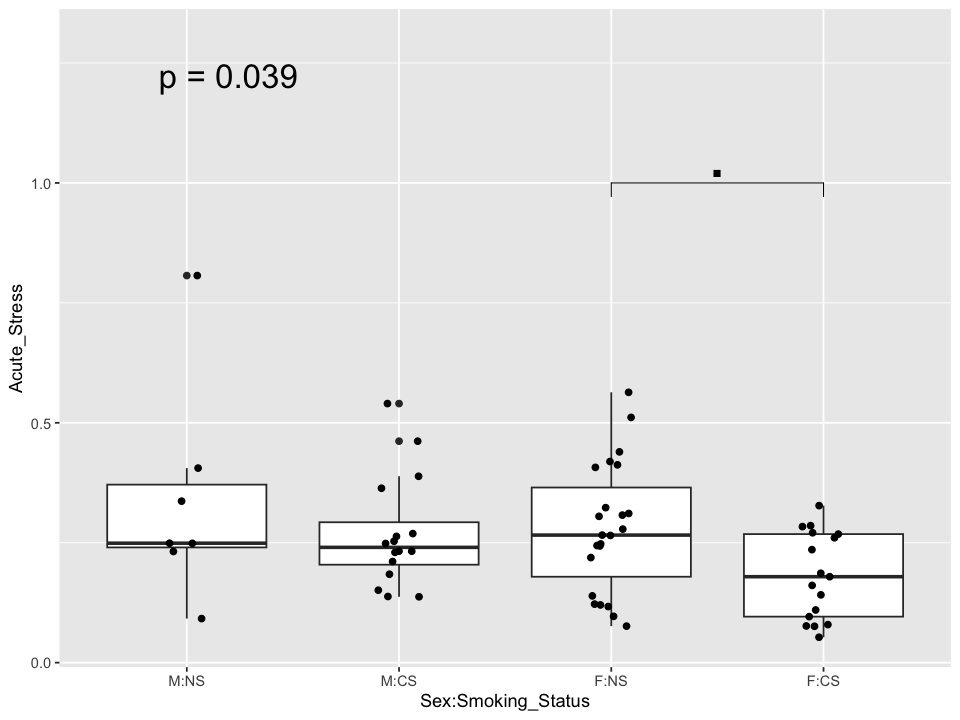

In [105]:
ggplot(data = boxplot_df, aes(x = Sex:Smoking_Status, y = Acute_Stress)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1.3) + 

  # overall anova p value
  stat_anova_test(wid = "Sex:Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.2) +

  # adjusted p value
  stat_pvalue_manual(adjusted_t_test_p_values %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 15)

## Chronic Stress

In [109]:
# calling anova fn
three_anova_smoking_race_chronic = get_anova(three_anova_df, 'Smoking_Status', 'Race', 'Chronic_Stress', "Three")
three_anova_smoking_sex_chronic = get_anova(three_anova_df, 'Smoking_Status', 'Sex', 'Chronic_Stress', "Three")
three_anova_sex_race_chronic = get_anova(three_anova_df, 'Sex', 'Race', 'Chronic_Stress', "Three")
two_anova_smoking_race_chronic = get_anova(two_anova_df, 'Smoking_Status', 'Race', 'Chronic_Stress', "Two")
two_anova_smoking_sex_chronic = get_anova(two_anova_df, 'Smoking_Status', 'Sex', 'Chronic_Stress', "Two")
two_anova_sex_race_chronic = get_anova(two_anova_df, 'Sex', 'Race', 'Chronic_Stress', "Two")

# creating 1 df
chronic_anova_df = unique(rbind(three_anova_smoking_race_chronic, three_anova_smoking_sex_chronic,
                            three_anova_sex_race_chronic, two_anova_smoking_race_chronic, 
                                two_anova_smoking_sex_chronic, two_anova_smoking_race_chronic)) %>%
    # adjusting
    #group_by(BP_Class) %>%
    mutate(P_Adj = p.adjust(as.numeric(as.character(P_Value)), method = "fdr"))

In [112]:
# viewing sig results
chronic_anova_df %>%
    filter(P_Adj < 0.1)

Outcome,BP_Class,Comparison,F_Value,P_Value,P_Adj
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Chronic_Stress,Three,Race,9.560772,0.003033896,0.02275422
Chronic_Stress,Three,Sex : Race,5.808469,0.019085653,0.09542826
Chronic_Stress,Two,Race,9.560772,0.003033896,0.02275422


ADD WORDS

In [114]:
# calling fn
three_tukey_smoking_race_chronic = get_tukey(three_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Three")
three_tukey_smoking_sex_chronic = get_tukey(three_anova_df, 'Smoking_Status', 'Sex', 'Acute_Stress', "Three")
three_tukey_sex_race_chronic = get_tukey(three_anova_df, 'Sex', 'Race', 'Acute_Stress', "Three")
two_tukey_smoking_race_chronic = get_tukey(two_anova_df, 'Smoking_Status', 'Race', 'Acute_Stress', "Two")
two_tukey_smoking_sex_chronic = get_tukey(two_anova_df, 'Smoking_Status', 'Sex', 'Acute_Stress', "Two")
two_tukey_sex_race_chronic = get_tukey(two_anova_df, 'Sex', 'Race', 'Acute_Stress', "Two")

# creating 1 df
chronic_tukey_df = rbind(three_tukey_smoking_race_chronic, three_tukey_smoking_sex_chronic,
                            three_tukey_sex_race_chronic, two_tukey_smoking_race_chronic, 
                            two_tukey_smoking_sex_chronic, two_tukey_smoking_race_chronic) %>%
    # only need results from interactions
    filter(grepl(":", term))

In [115]:
# viewing sig results
chronic_tukey_df %>%
    filter(p.adj < 0.1)

Outcome,BP_Class,term,group1,group2,estimate,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Acute_Stress,Three,Smoking_Status:Sex,NS:M,CS:F,-0.15691188,0.0511,ns
Acute_Stress,Three,Sex:Race,M:W,F:W,-0.13763563,0.0294,*
Acute_Stress,Three,Sex:Race,M:W,M:B,-0.14106353,0.0610,ns
Acute_Stress,Two,Smoking_Status:Sex,NS:F,CS:F,-0.09702454,0.0855,ns


There are statistically significant differences in chronic allostatic load (stress) based on race (p value = 0.03). The interaction between sex and race was significant (p value < 0.01). 

Tukey's post hoc tests revealed that white females have a higher chronic AL than black females (p adj < 0.05).?

In [41]:
# insert another boxplot for smoking??

In [118]:
# plotting t test values instead of tukey's since
# it gives me both the p values and adjusted p values
adjusted_t_test_p_values = compare_means(Chronic_Stress ~ Sex:Race, data = boxplot_df, method = "t.test") %>%
    # basing the p.signif off of adjusted p values
    mutate(p.signif = ifelse(p.adj < 0.0001, '****', 
                             ifelse(p.adj >= 0.0001 & p.adj < 0.001, '***',
                                   ifelse(p.adj >= 0.001 & p.adj < 0.01, '**',
                                         ifelse(p.adj >= 0.01 & p.adj < 0.05, '*', 
                                                ifelse(p.adj >= 0.05 & p.adj < 0.1, '.', 
                                                    'ns')))))) %>%
    # manually adding the y position
    mutate(y.position = c(1.2, 1, 1, 1.5, 1, 1))

adjusted_t_test_p_values

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Chronic_Stress,M:W,F:W,0.166445263,0.5000,0.1664,ns,T-test,1.2
Chronic_Stress,M:W,F:B,0.064645064,0.2600,0.0646,ns,T-test,1.0
Chronic_Stress,M:W,M:B,0.770877232,0.7700,0.7709,ns,T-test,1.0
Chronic_Stress,F:W,F:B,0.001389908,0.0083,0.0014,**,T-test,1.5
Chronic_Stress,F:W,M:B,0.306787309,0.6100,0.3068,ns,T-test,1.0
Chronic_Stress,F:B,M:B,0.043933900,0.2200,0.0439,ns,T-test,1.0


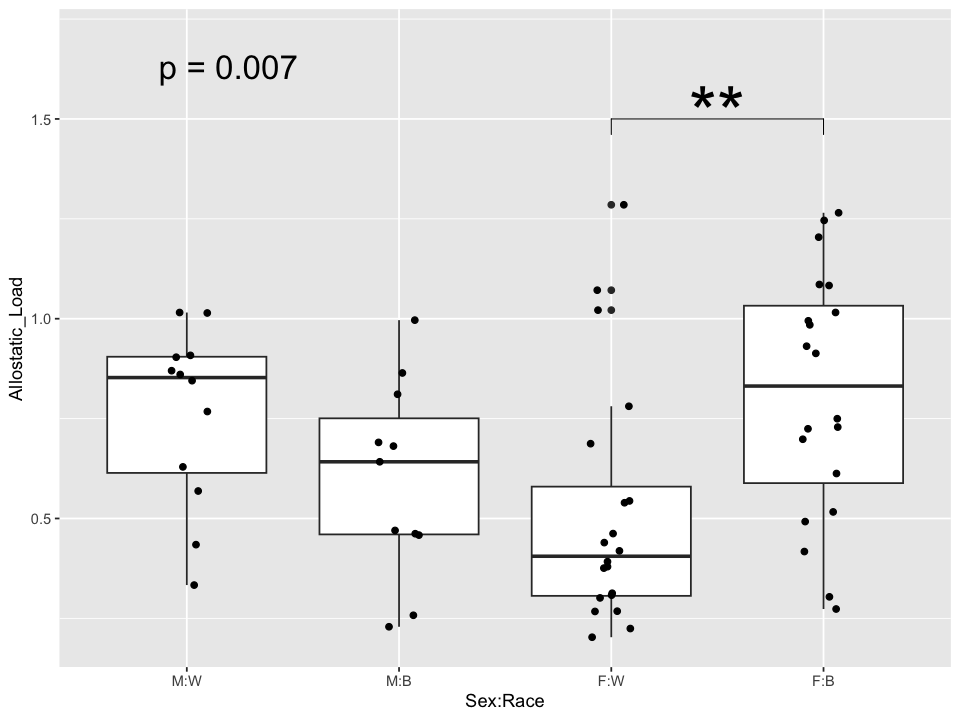

In [119]:
ggplot(data = boxplot_df, aes(x = Sex:Race, y = Allostatic_Load)) + 
  geom_boxplot() + 
  geom_point(position = position_jitter(w = 0.1)) + 

  # adding more space for p value significance
  ylim(NA, 1.7) + 

  # overall anova p value
  stat_anova_test(wid = "Sex:Race", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 7, label.y = 1.6) +
#   # unadjusted p value
#   stat_compare_means(comparisons = significant_comparisons, label = "p.signif", hide.ns = TRUE, size = 10) #+

  # adjusted p value
  stat_pvalue_manual(adjusted_t_test_p_values %>%
                         filter(p.signif != 'ns'), label = "p.signif", size = 15)

# Recap of Significant Results
**Overall AL**
+ *Interaction of Sex and Race*
    + black females have a higher AL than white females
    + Putting Fibrinogen into the chronic stress allowed the two-way anova to pick up more potential significant associations including smoking status and race

**Acute Stress**
+ *Smoking Status*
    + non-smokers had higher acute stress than cigarette smokers
+ *Race*
    + Removing Fibrinogen made this significant, but only when using the 3 class ordinal weights
+ *Interaction of Sex and Race*
    + only significant when using the ordinal weights derived from the 3 class BP prediction
    + white females have a higher acute stress than white males

**Chronic Stress**
+ *Race*
  + black subjects have higher chronic stress than white subjects
  + Adding Fibrinogen made this even more significant
+ *Interaction of Sex and Race*
    + black females have a higher chronic stress than white females